In [1]:
# coding: utf-8

# In[1]:

import numpy as np
#import h5py
#import tensorflow as tf
#import matplotlib.pyplot as plt
import tensorflow as tf
import h5py
#from scipy import signal
from tensorflow.python.keras.layers import Input,Conv2D,Concatenate,Flatten,Dense,LeakyReLU,Dropout, ReLU,Softmax
from tensorflow.python.keras.callbacks import TensorBoard,ModelCheckpoint
from tensorflow.python.keras.models import Model

from tensorflow.python.keras.losses import categorical_crossentropy
from tensorflow.python.keras import backend as K

from tensorflow.python.keras.activations import relu
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.utils import to_categorical

from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

import pickle

from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
fn = 2
d_min = 1
d_max = 10
blur_filter_size = 11
blur_range = 10
image_size = 512
epochs = 30
batch_size = 28

In [3]:
train_data_path = 'train_data_8000_dis_raw.npy'
test_data_path = 'real_data_2000.npy'
train_label_path = 'train_label_8000_dis_raw.npy'
test_label_path = 'real_label_2000.npy'

In [4]:
train_data = np.load(train_data_path)#[:2000, :, :, :]
test_data = np.load(test_data_path)
train_label = np.load(train_label_path)#[:2000, :]
test_label = np.load(test_label_path)
# test_label = (abs(test_label[:, 0] - test_label[:, 1]) <= 33)

In [5]:
# train_data = data[:10000, :, :, :]
# train_label = label[:10000, :]

In [6]:
#to_categorical(train_label[:, 2]).shape
import matplotlib.pyplot as plt
%matplotlib inline
idx = 7
plt.imshow(train_data[idx, :, :, 0])

print(train_label[idx, :])

[1.    1.074 0.   ]
Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f7a5c04b8c8> (for post_execute):


ValueError: Unsupported dtype

ValueError: Unsupported dtype

<Figure size 432x288 with 1 Axes>

[1.    0.992 0.   ]


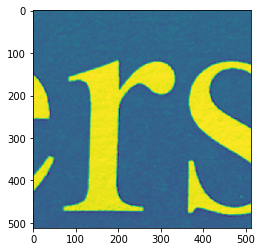

In [7]:
plt.imshow(test_data[idx, :, :, 0])

print(test_label[idx])

In [8]:
# In[7]:
input_image1 = Input(shape=(512,512,1), name = "input")
#layer1_1 = Conv2D(4, (8, 8), 8,padding='valid',activation=None,use_bias=False,kernel_initializer = my_init,trainable=True,name='layer1')(input_image1)
layer1_1 = Conv2D(4, (5, 5), 2,padding='same',activation=relu, name="Conv1_1")(input_image1)

layer2_1 = Conv2D(8, (5, 5), 4,padding='same',activation=relu, name="Conv2_1")(layer1_1)

layer3_1 = Conv2D(8, (5, 5), 4,padding='same',activation=relu, name="Conv3_1")(layer2_1)

#layer3_1 = Conv2D(32, (3, 3), 2,padding='same',activation=relu, name="Conv3_1")(layer2_1)

#layer4_1 = Conv2D(32, (3, 3), 2,padding='same',activation=relu, name="Conv4_1")(layer3_1)

flattened = Flatten(name="flat")(layer3_1)

dense1 = Dense(10, name="d1")(flattened)
Dp1 = Dropout(0.5)(dense1)
ReLU1 = ReLU(name="lr1")(dense1)

output_position = Dense(2, activation='softmax', name="out")(Dp1)

print(output_position)

model = Model(inputs=input_image1, outputs=output_position)
model.summary()

tcbc = TensorBoard(log_dir='1')

filepath="models/dis_train_on_generate/weights-{epoch:03d}-{val_acc:.3f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False, save_weights_only=True,mode='max',period=2)


print(model.output_shape)

Tensor("out/Softmax:0", shape=(?, 2), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 512, 512, 1)       0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 256, 256, 4)       104       
_________________________________________________________________
Conv2_1 (Conv2D)             (None, 64, 64, 8)         808       
_________________________________________________________________
Conv3_1 (Conv2D)             (None, 16, 16, 8)         1608      
_________________________________________________________________
flat (Flatten)               (None, 2048)              0         
_________________________________________________________________
d1 (Dense)                   (None, 10)                20490     
_________________________________________________________________
dropout (Dropout)      

In [9]:
def data_gen(features, labels, batch_size):
    while True:
        for i in np.arange(0, features.shape[0] - batch_size, batch_size):
            # choose random index in features
            batch_features = features[i:i+batch_size, :, :, :]
            batch_labels = labels[i:i+batch_size, :]
            yield (batch_features, batch_labels)

In [10]:
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0001)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)

# model.fit(train_data[:,:,:,0:1].astype('float16')/255.0, to_categorical(train_label[:, 2:]), 
#           epochs = 100,batch_size = batch_size,
#           validation_data=(test_data[:,:,:,0:1].astype('float16')/255.0, to_categorical(test_label)), 
#           verbose=1, callbacks = [tcbc, checkpoint])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    train_data, train_label, test_size=0.25, random_state=2233)

In [12]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

datatest = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True)

datatest.fit(X_test)

In [13]:
history = model.fit_generator(datagen.flow(X_train, to_categorical(y_train[:, 2:]), batch_size), 
                    steps_per_epoch = train_data.shape[0]/batch_size, epochs = epochs,
                    validation_data=datatest.flow(X_test, to_categorical(y_test[:, 2:]), batch_size), 
                    validation_steps = batch_size)#, verbose=1, callbacks = [tcbc, checkpoint])

Epoch 1/30
286/285 [==============================] - 118s 414ms/step - loss: 0.4383 - acc: 0.8080 - val_loss: 0.8250 - val_acc: 0.7997
Epoch 2/30
286/285 [==============================] - 82s 285ms/step - loss: 0.2555 - acc: 0.9160 - val_loss: 0.3338 - val_acc: 0.9018
Epoch 3/30
286/285 [==============================] - 83s 289ms/step - loss: 0.2337 - acc: 0.9258 - val_loss: 0.1862 - val_acc: 0.9245
Epoch 4/30
286/285 [==============================] - 83s 289ms/step - loss: 0.1948 - acc: 0.9379 - val_loss: 0.1952 - val_acc: 0.9209
Epoch 5/30
286/285 [==============================] - 82s 288ms/step - loss: 0.1792 - acc: 0.9470 - val_loss: 0.1626 - val_acc: 0.9466
Epoch 6/30
286/285 [==============================] - 82s 288ms/step - loss: 0.1593 - acc: 0.9554 - val_loss: 0.1491 - val_acc: 0.9452
Epoch 7/30
286/285 [==============================] - 83s 288ms/step - loss: 0.1403 - acc: 0.9589 - val_loss: 0.1420 - val_acc: 0.9439
Epoch 8/30
286/285 [==============================] - 

In [15]:
with open('trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

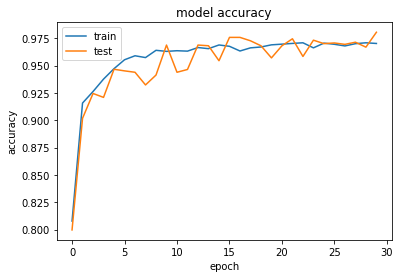

In [17]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

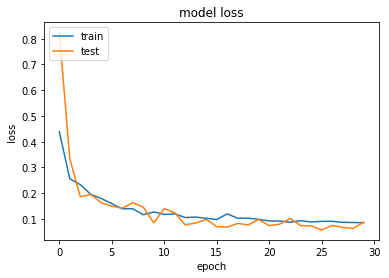

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
model.save('my_model_raw.h5')

model.save_weights('my_dis_raw_weights.h5')
# from tensorflow.python.keras.models import load_model
# model.load_weights('models/dis_train_on_generate/n_weights-078-0.939.h5')

In [23]:
pred  = model.predict(X_test[:15, :, :, :])

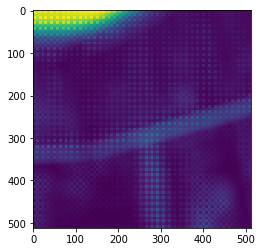

[1.   0.95 0.  ]
[9.9955529e-01 4.4467975e-04]


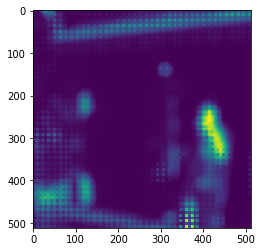

[1.    1.034 0.   ]
[9.9957758e-01 4.2237475e-04]


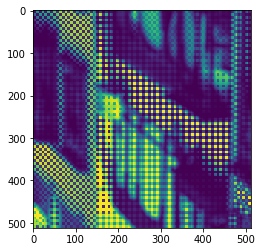

[1.    1.016 0.   ]
[9.993704e-01 6.295864e-04]


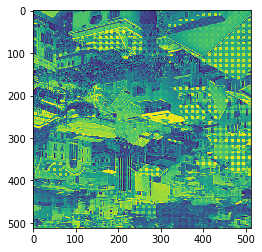

[1. 1. 1.]
[1.1474437e-12 1.0000000e+00]


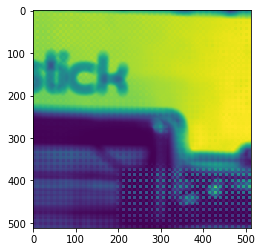

[1.    1.028 0.   ]
[9.9916303e-01 8.3693594e-04]


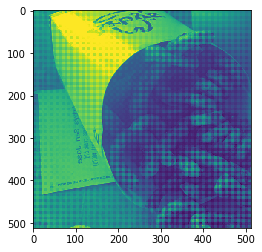

[1. 1. 1.]
[0.06423938 0.93576056]


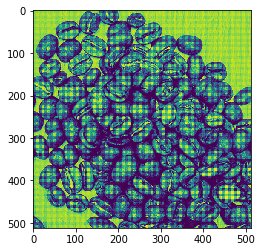

[1. 1. 1.]
[3.8169382e-08 1.0000000e+00]


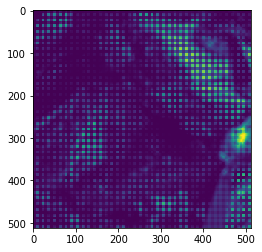

[1.    1.013 0.   ]
[9.9962354e-01 3.7645176e-04]


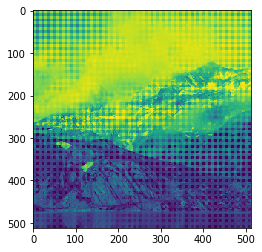

[1. 1. 1.]
[0.00160183 0.9983981 ]


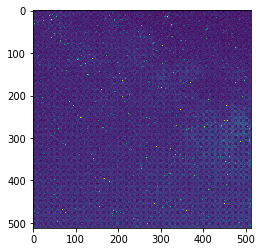

[1. 1. 1.]
[1.5058954e-11 1.0000000e+00]


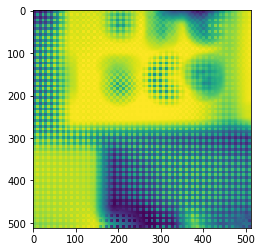

[1.    0.944 0.   ]
[0.9988771  0.00112289]


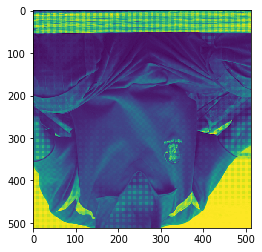

[1. 1. 1.]
[0.00604362 0.9939564 ]


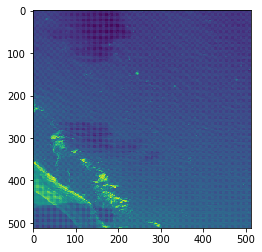

[1. 1. 1.]
[0.15664157 0.84335846]


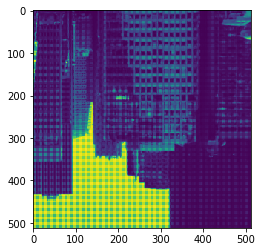

[1.    0.997 1.   ]
[0.5629015 0.4370985]


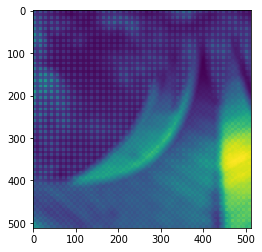

[1.    1.025 0.   ]
[9.9947697e-01 5.2309595e-04]


In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
for idx in range(15):
    plt.imshow(X_test[idx, :, :, 0].astype(np.float32))
    plt.show()
    print(y_test[idx, :])
    print(pred[idx, :])